In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE2_TSNE2.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, apply_tsne=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())  # 提取池化后的输出

    embeddings = np.vstack(embeddings)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        embeddings = tsne.fit_transform(embeddings)
        print(f"Reference embeddings reduced to {n_components} dimensions using t-SNE.")
    
    return embeddings

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:43<00:00,  3.60it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:03<00:00, 99.86it/s] 


Reference embeddings reduced to 2 dimensions using t-SNE.
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.15it/s]


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 104.84it/s]


Reference embeddings reduced to 2 dimensions using t-SNE.


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4 and hidden_dim=256


Training Epochs:   0%|          | 10/2000 [00:00<00:22, 86.98it/s]

Epoch 10/2000, Loss: 32.2975
Test Accuracy at Epoch 10: 48.02%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.43      0.20      0.27       283
non_infringement       0.50      0.74      0.60       298

        accuracy                           0.48       581
       macro avg       0.46      0.47      0.43       581
    weighted avg       0.46      0.48      0.44       581

New best model saved with accuracy 48.02% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.43      0.20      0.27       283
non_infringement       0.50      0.74      0.60       298

        accuracy                           0.48       581
       macro avg       0.46      0.47      0.43       581
    weighted avg       0.46      0.48      0.44       581



Training Epochs:   1%|          | 21/2000 [00:00<00:21, 93.84it/s]

Epoch 20/2000, Loss: 11.8038
Test Accuracy at Epoch 20: 59.90%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

New best model saved with accuracy 59.90% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:   2%|▏         | 31/2000 [00:00<00:23, 83.43it/s]

Epoch 30/2000, Loss: 10.1683
Test Accuracy at Epoch 30: 54.39%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.53      0.50      0.52       283
non_infringement       0.55      0.59      0.57       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581



Training Epochs:   2%|▏         | 44/2000 [00:00<00:20, 97.06it/s]

Epoch 40/2000, Loss: 6.7302
Test Accuracy at Epoch 40: 53.18%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.53      0.38      0.44       283
non_infringement       0.53      0.68      0.60       298

        accuracy                           0.53       581
       macro avg       0.53      0.53      0.52       581
    weighted avg       0.53      0.53      0.52       581

Epoch 50/2000, Loss: 4.7437
Test Accuracy at Epoch 50: 52.50%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.52      0.37      0.43       283
non_infringement       0.53      0.67      0.59       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.51       581
    weighted avg       0.52      0.52      0.51       581



Training Epochs:   3%|▎         | 57/2000 [00:00<00:18, 107.25it/s]

Epoch 60/2000, Loss: 3.6175
Test Accuracy at Epoch 60: 53.87%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.53      0.42      0.47       283
non_infringement       0.54      0.65      0.59       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.53       581
    weighted avg       0.54      0.54      0.53       581



Training Epochs:   4%|▎         | 70/2000 [00:00<00:19, 99.93it/s] 

Epoch 70/2000, Loss: 2.8390
Test Accuracy at Epoch 70: 55.59%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.55      0.47      0.51       283
non_infringement       0.56      0.64      0.60       298

        accuracy                           0.56       581
       macro avg       0.56      0.55      0.55       581
    weighted avg       0.56      0.56      0.55       581



Training Epochs:   4%|▍         | 82/2000 [00:00<00:18, 104.12it/s]

Epoch 80/2000, Loss: 2.2912
Test Accuracy at Epoch 80: 58.35%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.55       283
non_infringement       0.58      0.65      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:   5%|▍         | 95/2000 [00:00<00:17, 109.85it/s]

Epoch 90/2000, Loss: 1.9345
Test Accuracy at Epoch 90: 54.22%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.53      0.47      0.50       283
non_infringement       0.55      0.61      0.58       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581

Epoch 100/2000, Loss: 1.6584
Test Accuracy at Epoch 100: 56.80%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.57      0.48      0.52       283
non_infringement       0.57      0.65      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:   5%|▌         | 108/2000 [00:01<00:16, 114.57it/s]

Epoch 110/2000, Loss: 1.4224
Test Accuracy at Epoch 110: 56.63%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.57      0.47      0.52       283
non_infringement       0.57      0.65      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.56      0.56       581
    weighted avg       0.57      0.57      0.56       581



Training Epochs:   6%|▌         | 120/2000 [00:01<00:19, 97.68it/s] 

Epoch 120/2000, Loss: 1.2130
Test Accuracy at Epoch 120: 56.45%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.57      0.45      0.50       283
non_infringement       0.56      0.67      0.61       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:   7%|▋         | 133/2000 [00:01<00:17, 105.94it/s]

Epoch 130/2000, Loss: 1.0285
Test Accuracy at Epoch 130: 56.63%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.57      0.46      0.51       283
non_infringement       0.57      0.66      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.56      0.56       581
    weighted avg       0.57      0.57      0.56       581

Epoch 140/2000, Loss: 0.8780
Test Accuracy at Epoch 140: 57.49%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.58      0.47      0.52       283
non_infringement       0.57      0.67      0.62       298

        accuracy                           0.57       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.57      0.57       581



Training Epochs:   7%|▋         | 147/2000 [00:01<00:16, 113.39it/s]

Epoch 150/2000, Loss: 0.7647
Test Accuracy at Epoch 150: 58.18%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.58      0.49      0.53       283
non_infringement       0.58      0.67      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:   8%|▊         | 159/2000 [00:01<00:18, 102.12it/s]

Epoch 160/2000, Loss: 0.6718
Test Accuracy at Epoch 160: 57.83%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.58      0.48      0.53       283
non_infringement       0.58      0.67      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581



Training Epochs:   9%|▊         | 172/2000 [00:01<00:16, 107.60it/s]

Epoch 170/2000, Loss: 0.5919
Test Accuracy at Epoch 170: 57.66%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.58      0.48      0.53       283
non_infringement       0.58      0.66      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 180/2000, Loss: 0.5251
Test Accuracy at Epoch 180: 57.49%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.58      0.48      0.53       283
non_infringement       0.57      0.66      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:   9%|▉         | 184/2000 [00:01<00:16, 109.33it/s]

Epoch 190/2000, Loss: 0.4763
Test Accuracy at Epoch 190: 57.14%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.57      0.47      0.52       283
non_infringement       0.57      0.66      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  10%|█         | 209/2000 [00:02<00:17, 104.49it/s]

Epoch 200/2000, Loss: 0.4310
Test Accuracy at Epoch 200: 56.28%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.57      0.44      0.49       283
non_infringement       0.56      0.68      0.62       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.55       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  11%|█         | 221/2000 [00:02<00:16, 108.08it/s]

Epoch 210/2000, Loss: 0.3967
Test Accuracy at Epoch 210: 58.18%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.58      0.50      0.54       283
non_infringement       0.58      0.66      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 220/2000, Loss: 0.3629
Test Accuracy at Epoch 220: 56.28%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.57      0.44      0.49       283
non_infringement       0.56      0.68      0.62       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.55       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  12%|█▏        | 234/2000 [00:02<00:15, 112.07it/s]

Epoch 230/2000, Loss: 0.3312
Test Accuracy at Epoch 230: 56.97%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.57      0.46      0.51       283
non_infringement       0.57      0.67      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.56       581



Training Epochs:  12%|█▏        | 246/2000 [00:02<00:17, 99.81it/s] 

Epoch 240/2000, Loss: 0.3003
Test Accuracy at Epoch 240: 57.83%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.58      0.47      0.52       283
non_infringement       0.58      0.68      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 250/2000, Loss: 0.2775
Test Accuracy at Epoch 250: 57.49%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.57      0.57       581



Training Epochs:  13%|█▎        | 268/2000 [00:02<00:17, 97.10it/s] 

Epoch 260/2000, Loss: 0.2572
Test Accuracy at Epoch 260: 57.31%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 270/2000, Loss: 0.2399
Test Accuracy at Epoch 270: 56.63%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.57      0.44      0.50       283
non_infringement       0.56      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.56      0.56       581
    weighted avg       0.57      0.57      0.56       581



Training Epochs:  14%|█▍        | 278/2000 [00:02<00:19, 89.22it/s]

Epoch 280/2000, Loss: 0.2232
Test Accuracy at Epoch 280: 57.14%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.58      0.45      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  15%|█▌        | 303/2000 [00:02<00:16, 105.34it/s]

Epoch 290/2000, Loss: 0.2095
Test Accuracy at Epoch 290: 57.31%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 300/2000, Loss: 0.1976
Test Accuracy at Epoch 300: 57.66%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.52       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 310/2000, Loss: 0.1871
Test Accuracy at Epoch 310: 57.31%
Classification Report at Epoch 310

Training Epochs:  16%|█▌        | 316/2000 [00:03<00:15, 112.09it/s]

Epoch 320/2000, Loss: 0.1776
Test Accuracy at Epoch 320: 57.14%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  16%|█▋        | 328/2000 [00:03<00:17, 96.30it/s] 

Epoch 330/2000, Loss: 0.1691
Test Accuracy at Epoch 330: 57.66%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.69      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581



Training Epochs:  18%|█▊        | 353/2000 [00:03<00:15, 106.43it/s]

Epoch 340/2000, Loss: 0.1614
Test Accuracy at Epoch 340: 57.66%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.69      0.63       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 350/2000, Loss: 0.1544
Test Accuracy at Epoch 350: 58.00%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.59      0.46      0.52       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 360/2000, Loss: 0.1479
Test Accuracy at Epoch 360: 58.18%
Classification Report at Epoch 360

Training Epochs:  19%|█▉        | 376/2000 [00:03<00:16, 99.85it/s] 

Epoch 370/2000, Loss: 0.1419
Test Accuracy at Epoch 370: 58.35%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.59      0.47      0.52       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.58       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:  19%|█▉        | 388/2000 [00:03<00:15, 103.39it/s]

Epoch 380/2000, Loss: 0.1364
Test Accuracy at Epoch 380: 59.21%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581

Epoch 390/2000, Loss: 0.1313
Test Accuracy at Epoch 390: 59.21%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  20%|██        | 400/2000 [00:03<00:15, 100.63it/s]

Epoch 400/2000, Loss: 0.1265
Test Accuracy at Epoch 400: 58.86%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  21%|██        | 411/2000 [00:04<00:15, 100.02it/s]

Epoch 410/2000, Loss: 0.1221
Test Accuracy at Epoch 410: 59.38%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       283
non_infringement       0.58      0.72      0.65       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.59       581



Training Epochs:  21%|██        | 423/2000 [00:04<00:15, 104.28it/s]

Epoch 420/2000, Loss: 0.1179
Test Accuracy at Epoch 420: 59.21%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       283
non_infringement       0.58      0.72      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.58       581

Epoch 430/2000, Loss: 0.1140
Test Accuracy at Epoch 430: 59.38%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       283
non_infringement       0.58      0.72      0.65       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.59       581



Training Epochs:  22%|██▏       | 434/2000 [00:04<00:14, 104.54it/s]

Epoch 440/2000, Loss: 0.1103
Test Accuracy at Epoch 440: 59.38%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       283
non_infringement       0.58      0.72      0.65       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.59       581



Training Epochs:  23%|██▎       | 459/2000 [00:04<00:14, 108.99it/s]

Epoch 450/2000, Loss: 0.1068
Test Accuracy at Epoch 450: 59.21%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       283
non_infringement       0.58      0.72      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.58       581

Epoch 460/2000, Loss: 0.1035
Test Accuracy at Epoch 460: 59.04%


Training Epochs:  24%|██▎       | 472/2000 [00:04<00:13, 113.80it/s]

Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 470/2000, Loss: 0.1003
Test Accuracy at Epoch 470: 58.86%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  24%|██▍       | 486/2000 [00:04<00:12, 119.05it/s]

Epoch 480/2000, Loss: 0.0973
Test Accuracy at Epoch 480: 58.69%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  25%|██▍       | 498/2000 [00:04<00:14, 106.38it/s]

Epoch 490/2000, Loss: 0.0944
Test Accuracy at Epoch 490: 58.35%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.59      0.46      0.52       283
non_infringement       0.58      0.70      0.63       298

        accuracy                           0.58       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.58      0.58       581



Training Epochs:  26%|██▌       | 510/2000 [00:04<00:13, 109.16it/s]

Epoch 500/2000, Loss: 0.0916
Test Accuracy at Epoch 500: 58.52%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 510/2000, Loss: 0.0890
Test Accuracy at Epoch 510: 58.69%
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  26%|██▌       | 524/2000 [00:05<00:12, 116.91it/s]

Epoch 520/2000, Loss: 0.0864
Test Accuracy at Epoch 520: 58.52%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  27%|██▋       | 536/2000 [00:05<00:14, 104.17it/s]

Epoch 530/2000, Loss: 0.0839
Test Accuracy at Epoch 530: 58.52%
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 540/2000, Loss: 0.0816
Test Accuracy at Epoch 540: 58.69%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  28%|██▊       | 562/2000 [00:05<00:12, 114.00it/s]

Epoch 550/2000, Loss: 0.0793
Test Accuracy at Epoch 550: 58.69%
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 560/2000, Loss: 0.0771
Test Accuracy at Epoch 560: 58.69%
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  29%|██▉       | 575/2000 [00:05<00:12, 118.07it/s]

Epoch 570/2000, Loss: 0.0751
Test Accuracy at Epoch 570: 58.86%
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  29%|██▉       | 588/2000 [00:05<00:13, 107.62it/s]

Epoch 580/2000, Loss: 0.0731
Test Accuracy at Epoch 580: 59.04%
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  30%|███       | 600/2000 [00:05<00:12, 110.76it/s]

Epoch 590/2000, Loss: 0.0713
Test Accuracy at Epoch 590: 59.21%
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581

Epoch 600/2000, Loss: 0.0695
Test Accuracy at Epoch 600: 59.21%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  31%|███       | 613/2000 [00:05<00:11, 115.65it/s]

Epoch 610/2000, Loss: 0.0678
Test Accuracy at Epoch 610: 59.21%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  31%|███▏      | 625/2000 [00:05<00:13, 105.13it/s]

Epoch 620/2000, Loss: 0.0662
Test Accuracy at Epoch 620: 58.86%
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  32%|███▏      | 639/2000 [00:06<00:12, 112.58it/s]

Epoch 630/2000, Loss: 0.0646
Test Accuracy at Epoch 630: 59.04%
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  33%|███▎      | 651/2000 [00:06<00:12, 107.98it/s]

Epoch 640/2000, Loss: 0.0632
Test Accuracy at Epoch 640: 59.38%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.59      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.59      0.59       581

Epoch 650/2000, Loss: 0.0617
Test Accuracy at Epoch 650: 59.55%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.59      0.71      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 660/2000, Loss: 0.0604
Test Accuracy at Epoch 660: 59.55%
Classification Report at Epoch 660

Training Epochs:  34%|███▍      | 676/2000 [00:06<00:12, 104.20it/s]

Epoch 670/2000, Loss: 0.0590
Test Accuracy at Epoch 670: 59.38%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.59      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.59      0.59       581



Training Epochs:  34%|███▍      | 689/2000 [00:06<00:11, 109.73it/s]

Epoch 680/2000, Loss: 0.0578
Test Accuracy at Epoch 680: 59.21%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581

Epoch 690/2000, Loss: 0.0565
Test Accuracy at Epoch 690: 59.21%
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.60      0.48      0.53       283
non_infringement       0.59      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  35%|███▌      | 702/2000 [00:06<00:11, 113.00it/s]

Epoch 700/2000, Loss: 0.0553
Test Accuracy at Epoch 700: 59.55%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.61      0.49      0.54       283
non_infringement       0.59      0.70      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:  36%|███▌      | 714/2000 [00:06<00:12, 104.83it/s]

Epoch 710/2000, Loss: 0.0542
Test Accuracy at Epoch 710: 59.55%
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.61      0.49      0.54       283
non_infringement       0.59      0.70      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:  36%|███▋      | 727/2000 [00:06<00:11, 110.03it/s]

Epoch 720/2000, Loss: 0.0531
Test Accuracy at Epoch 720: 59.38%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.59      0.59       581

Epoch 730/2000, Loss: 0.0520
Test Accuracy at Epoch 730: 59.21%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  37%|███▋      | 740/2000 [00:06<00:11, 112.26it/s]

Epoch 740/2000, Loss: 0.0509
Test Accuracy at Epoch 740: 59.04%
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  38%|███▊      | 753/2000 [00:07<00:11, 106.28it/s]

Epoch 750/2000, Loss: 0.0499
Test Accuracy at Epoch 750: 58.86%
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.60      0.48      0.53       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  38%|███▊      | 764/2000 [00:07<00:11, 106.83it/s]

Epoch 760/2000, Loss: 0.0489
Test Accuracy at Epoch 760: 59.21%
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  39%|███▉      | 777/2000 [00:07<00:10, 112.85it/s]

Epoch 770/2000, Loss: 0.0479
Test Accuracy at Epoch 770: 59.21%
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 780/2000, Loss: 0.0470
Test Accuracy at Epoch 780: 59.04%
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  40%|███▉      | 790/2000 [00:07<00:10, 115.34it/s]

Epoch 790/2000, Loss: 0.0460
Test Accuracy at Epoch 790: 59.38%
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  40%|████      | 802/2000 [00:07<00:11, 104.59it/s]

Epoch 800/2000, Loss: 0.0451
Test Accuracy at Epoch 800: 59.72%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.60      0.50      0.55       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:  41%|████      | 814/2000 [00:07<00:11, 107.51it/s]

Epoch 810/2000, Loss: 0.0443
Test Accuracy at Epoch 810: 59.90%
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.55       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581

Epoch 820/2000, Loss: 0.0434
Test Accuracy at Epoch 820: 59.90%
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.55       283
non_infringement       0.59      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  41%|████▏     | 826/2000 [00:07<00:10, 110.30it/s]

Epoch 830/2000, Loss: 0.0426
Test Accuracy at Epoch 830: 59.90%
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.55       283
non_infringement       0.59      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  42%|████▏     | 838/2000 [00:07<00:11, 97.60it/s] 

Epoch 840/2000, Loss: 0.0418
Test Accuracy at Epoch 840: 59.90%
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.55       283
non_infringement       0.59      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  42%|████▎     | 850/2000 [00:08<00:11, 100.87it/s]

Epoch 850/2000, Loss: 0.0410
Test Accuracy at Epoch 850: 59.90%
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.55       283
non_infringement       0.59      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581

Epoch 860/2000, Loss: 0.0403
Test Accuracy at Epoch 860: 60.24%
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

New best model saved with accuracy 60.24% at epoch 860
Best Classification Report at Epoch 860:
  

Training Epochs:  43%|████▎     | 862/2000 [00:08<00:11, 102.73it/s]

Epoch 870/2000, Loss: 0.0396
Test Accuracy at Epoch 870: 60.24%
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  44%|████▍     | 884/2000 [00:08<00:11, 94.95it/s] 

Epoch 880/2000, Loss: 0.0389
Test Accuracy at Epoch 880: 60.24%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  45%|████▍     | 896/2000 [00:08<00:10, 101.31it/s]

Epoch 890/2000, Loss: 0.0382
Test Accuracy at Epoch 890: 60.41%
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

New best model saved with accuracy 60.41% at epoch 890
Best Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 900/2000, Loss: 0.0376
Test Accuracy at Epoch 900: 60.41%
Classification Report at Epoch 900:
  

Training Epochs:  45%|████▌     | 908/2000 [00:08<00:10, 106.10it/s]

Epoch 910/2000, Loss: 0.0369
Test Accuracy at Epoch 910: 60.41%
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  46%|████▌     | 919/2000 [00:08<00:11, 94.15it/s] 

Epoch 920/2000, Loss: 0.0363
Test Accuracy at Epoch 920: 60.24%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  47%|████▋     | 944/2000 [00:08<00:09, 106.54it/s]

Epoch 930/2000, Loss: 0.0358
Test Accuracy at Epoch 930: 60.41%
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 940/2000, Loss: 0.0352
Test Accuracy at Epoch 940: 60.41%
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 950/2000, Loss: 0.0346
Test Accuracy at Epoch 950: 60.41%
Classification Report at Epoch 950

Training Epochs:  48%|████▊     | 957/2000 [00:09<00:09, 111.55it/s]

Epoch 960/2000, Loss: 0.0341
Test Accuracy at Epoch 960: 60.41%
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  49%|████▉     | 981/2000 [00:09<00:09, 103.49it/s]

Epoch 970/2000, Loss: 0.0336
Test Accuracy at Epoch 970: 60.41%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 980/2000, Loss: 0.0331
Test Accuracy at Epoch 980: 60.24%
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  50%|████▉     | 994/2000 [00:09<00:09, 109.61it/s]

Epoch 990/2000, Loss: 0.0326
Test Accuracy at Epoch 990: 60.24%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  50%|█████     | 1006/2000 [00:09<00:10, 98.89it/s]

Epoch 1000/2000, Loss: 0.0321
Test Accuracy at Epoch 1000: 60.24%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1010/2000, Loss: 0.0317
Test Accuracy at Epoch 1010: 60.24%
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  52%|█████▏    | 1033/2000 [00:09<00:08, 111.53it/s]

Epoch 1020/2000, Loss: 0.0312
Test Accuracy at Epoch 1020: 60.24%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1030/2000, Loss: 0.0308
Test Accuracy at Epoch 1030: 60.24%
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1040/2000, Loss: 0.0304
Test Accuracy at Epoch 1040: 60.07%
Classification Report at E

Training Epochs:  53%|█████▎    | 1057/2000 [00:10<00:08, 106.06it/s]

Epoch 1050/2000, Loss: 0.0300
Test Accuracy at Epoch 1050: 60.24%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  54%|█████▎    | 1070/2000 [00:10<00:08, 109.02it/s]

Epoch 1060/2000, Loss: 0.0296
Test Accuracy at Epoch 1060: 60.24%
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1070/2000, Loss: 0.0292
Test Accuracy at Epoch 1070: 60.41%
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  54%|█████▍    | 1082/2000 [00:10<00:08, 111.32it/s]

Epoch 1080/2000, Loss: 0.0288
Test Accuracy at Epoch 1080: 60.41%
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  55%|█████▍    | 1094/2000 [00:10<00:08, 102.10it/s]

Epoch 1090/2000, Loss: 0.0284
Test Accuracy at Epoch 1090: 60.41%
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  55%|█████▌    | 1107/2000 [00:10<00:08, 109.04it/s]

Epoch 1100/2000, Loss: 0.0280
Test Accuracy at Epoch 1100: 60.41%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1110/2000, Loss: 0.0277
Test Accuracy at Epoch 1110: 60.24%
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.66      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  56%|█████▌    | 1119/2000 [00:10<00:07, 111.40it/s]

Epoch 1120/2000, Loss: 0.0273
Test Accuracy at Epoch 1120: 60.07%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.65      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  57%|█████▋    | 1131/2000 [00:10<00:08, 100.85it/s]

Epoch 1130/2000, Loss: 0.0270
Test Accuracy at Epoch 1130: 59.90%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1140/2000, Loss: 0.0266
Test Accuracy at Epoch 1140: 59.90%
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  58%|█████▊    | 1154/2000 [00:10<00:08, 98.24it/s] 

Epoch 1150/2000, Loss: 0.0263
Test Accuracy at Epoch 1150: 59.90%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1160/2000, Loss: 0.0260
Test Accuracy at Epoch 1160: 59.90%
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.60      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  60%|█████▉    | 1191/2000 [00:11<00:07, 103.72it/s]

Epoch 1170/2000, Loss: 0.0257
Test Accuracy at Epoch 1170: 59.55%
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 1180/2000, Loss: 0.0253
Test Accuracy at Epoch 1180: 59.55%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 1190/2000, Loss: 0.0250
Test Accuracy at Epoch 1190: 59.55%
Classification Report at E

Training Epochs:  61%|██████    | 1214/2000 [00:11<00:08, 95.63it/s] 

Epoch 1200/2000, Loss: 0.0247
Test Accuracy at Epoch 1200: 59.55%
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 1210/2000, Loss: 0.0244
Test Accuracy at Epoch 1210: 59.55%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:  62%|██████▏   | 1236/2000 [00:11<00:07, 101.69it/s]

Epoch 1220/2000, Loss: 0.0242
Test Accuracy at Epoch 1220: 59.72%
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1230/2000, Loss: 0.0239
Test Accuracy at Epoch 1230: 59.72%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1240/2000, Loss: 0.0236
Test Accuracy at Epoch 1240: 59.55%
Classification Report at E

Training Epochs:  63%|██████▎   | 1258/2000 [00:12<00:08, 85.62it/s] 

Epoch 1250/2000, Loss: 0.0233
Test Accuracy at Epoch 1250: 59.90%
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1260/2000, Loss: 0.0231
Test Accuracy at Epoch 1260: 59.90%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  64%|██████▍   | 1280/2000 [00:12<00:07, 93.07it/s]

Epoch 1270/2000, Loss: 0.0228
Test Accuracy at Epoch 1270: 60.07%
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1280/2000, Loss: 0.0226
Test Accuracy at Epoch 1280: 60.07%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  65%|██████▌   | 1303/2000 [00:12<00:06, 100.92it/s]

Epoch 1290/2000, Loss: 0.0223
Test Accuracy at Epoch 1290: 60.07%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1300/2000, Loss: 0.0221
Test Accuracy at Epoch 1300: 59.72%
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1310/2000, Loss: 0.0218
Test Accuracy at Epoch 1310: 59.72%
Classification Report at E

Training Epochs:  66%|██████▋   | 1326/2000 [00:12<00:07, 92.96it/s] 

Epoch 1320/2000, Loss: 0.0216
Test Accuracy at Epoch 1320: 59.55%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 1330/2000, Loss: 0.0213
Test Accuracy at Epoch 1330: 59.72%
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  68%|██████▊   | 1361/2000 [00:13<00:06, 103.41it/s]

Epoch 1340/2000, Loss: 0.0211
Test Accuracy at Epoch 1340: 59.72%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1350/2000, Loss: 0.0209
Test Accuracy at Epoch 1350: 59.72%
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1360/2000, Loss: 0.0207
Test Accuracy at Epoch 1360: 59.72%
Classification Report at E

Training Epochs:  69%|██████▉   | 1385/2000 [00:13<00:05, 104.39it/s]

Epoch 1370/2000, Loss: 0.0204
Test Accuracy at Epoch 1370: 59.90%
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1380/2000, Loss: 0.0202
Test Accuracy at Epoch 1380: 59.90%
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1390/2000, Loss: 0.0200
Test Accuracy at Epoch 1390: 59.90%
Classification Report at E

Training Epochs:  70%|███████   | 1410/2000 [00:13<00:05, 98.42it/s] 

Epoch 1400/2000, Loss: 0.0198
Test Accuracy at Epoch 1400: 59.90%
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1410/2000, Loss: 0.0196
Test Accuracy at Epoch 1410: 59.90%
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  72%|███████▏  | 1432/2000 [00:13<00:05, 100.27it/s]

Epoch 1420/2000, Loss: 0.0194
Test Accuracy at Epoch 1420: 59.90%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1430/2000, Loss: 0.0192
Test Accuracy at Epoch 1430: 60.07%
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1440/2000, Loss: 0.0190
Test Accuracy at Epoch 1440: 60.07%
Classification Report at E

Training Epochs:  73%|███████▎  | 1469/2000 [00:14<00:05, 102.94it/s]

Epoch 1450/2000, Loss: 0.0188
Test Accuracy at Epoch 1450: 60.07%
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1460/2000, Loss: 0.0186
Test Accuracy at Epoch 1460: 60.24%
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1470/2000, Loss: 0.0184
Test Accuracy at Epoch 1470: 60.24%
Classification Report at E

Training Epochs:  75%|███████▍  | 1491/2000 [00:14<00:05, 93.77it/s] 

Epoch 1480/2000, Loss: 0.0182
Test Accuracy at Epoch 1480: 60.24%
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1490/2000, Loss: 0.0181
Test Accuracy at Epoch 1490: 60.24%
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  76%|███████▌  | 1516/2000 [00:14<00:04, 106.53it/s]

Epoch 1500/2000, Loss: 0.0179
Test Accuracy at Epoch 1500: 60.24%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1510/2000, Loss: 0.0177
Test Accuracy at Epoch 1510: 60.24%
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1520/2000, Loss: 0.0175
Test Accuracy at Epoch 1520: 60.24%
Classification Report at E

Training Epochs:  78%|███████▊  | 1550/2000 [00:14<00:04, 103.98it/s]

Epoch 1530/2000, Loss: 0.0174
Test Accuracy at Epoch 1530: 60.24%
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1540/2000, Loss: 0.0172
Test Accuracy at Epoch 1540: 60.24%
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1550/2000, Loss: 0.0170
Test Accuracy at Epoch 1550: 60.24%
Classification Report at E

Training Epochs:  79%|███████▊  | 1573/2000 [00:15<00:04, 96.18it/s] 

Epoch 1560/2000, Loss: 0.0168
Test Accuracy at Epoch 1560: 60.07%
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1570/2000, Loss: 0.0167
Test Accuracy at Epoch 1570: 60.07%
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  80%|███████▉  | 1599/2000 [00:15<00:03, 109.20it/s]

Epoch 1580/2000, Loss: 0.0165
Test Accuracy at Epoch 1580: 60.07%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1590/2000, Loss: 0.0164
Test Accuracy at Epoch 1590: 60.07%
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1600/2000, Loss: 0.0162
Test Accuracy at Epoch 1600: 60.07%
Classification Report at E

Training Epochs:  81%|████████▏ | 1625/2000 [00:15<00:03, 108.95it/s]

Epoch 1610/2000, Loss: 0.0160
Test Accuracy at Epoch 1610: 60.07%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1620/2000, Loss: 0.0159
Test Accuracy at Epoch 1620: 60.07%
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1630/2000, Loss: 0.0157
Test Accuracy at Epoch 1630: 60.07%
Classification Report at E

Training Epochs:  83%|████████▎ | 1652/2000 [00:15<00:02, 118.06it/s]

Epoch 1640/2000, Loss: 0.0156
Test Accuracy at Epoch 1640: 60.07%
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1650/2000, Loss: 0.0154
Test Accuracy at Epoch 1650: 60.07%
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  84%|████████▍ | 1679/2000 [00:16<00:02, 111.13it/s]

Epoch 1660/2000, Loss: 0.0153
Test Accuracy at Epoch 1660: 60.07%
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1670/2000, Loss: 0.0151
Test Accuracy at Epoch 1670: 60.07%
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1680/2000, Loss: 0.0150
Test Accuracy at Epoch 1680: 60.07%
Classification Report at E

Training Epochs:  85%|████████▌ | 1703/2000 [00:16<00:02, 104.46it/s]

Epoch 1690/2000, Loss: 0.0148
Test Accuracy at Epoch 1690: 60.07%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1700/2000, Loss: 0.0147
Test Accuracy at Epoch 1700: 60.07%
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1710/2000, Loss: 0.0145


Training Epochs:  86%|████████▋ | 1730/2000 [00:16<00:02, 115.86it/s]

Test Accuracy at Epoch 1710: 60.07%
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1720/2000, Loss: 0.0144
Test Accuracy at Epoch 1720: 60.07%
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1730/2000, Loss: 0.0143
Test Accuracy at Epoch 1730: 60.24%
Classification Report at Epoch 1730:
                  p

Training Epochs:  88%|████████▊ | 1757/2000 [00:16<00:02, 109.47it/s]

Epoch 1740/2000, Loss: 0.0141
Test Accuracy at Epoch 1740: 59.90%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1750/2000, Loss: 0.0140
Test Accuracy at Epoch 1750: 59.90%
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  89%|████████▉ | 1781/2000 [00:17<00:01, 112.25it/s]

Epoch 1760/2000, Loss: 0.0139
Test Accuracy at Epoch 1760: 59.90%
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1770/2000, Loss: 0.0137
Test Accuracy at Epoch 1770: 59.90%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1780/2000, Loss: 0.0136
Test Accuracy at Epoch 1780: 59.90%
Classification Report at E

Training Epochs:  90%|█████████ | 1806/2000 [00:17<00:01, 107.40it/s]

Epoch 1790/2000, Loss: 0.0135
Test Accuracy at Epoch 1790: 59.90%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1800/2000, Loss: 0.0133
Test Accuracy at Epoch 1800: 59.72%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1810/2000, Loss: 0.0132
Test Accuracy at Epoch 1810: 59.72%
Classification Report at E

Training Epochs:  92%|█████████▏| 1830/2000 [00:17<00:01, 109.51it/s]

Epoch 1820/2000, Loss: 0.0131
Test Accuracy at Epoch 1820: 59.72%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1830/2000, Loss: 0.0130
Test Accuracy at Epoch 1830: 59.72%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  93%|█████████▎| 1854/2000 [00:17<00:01, 106.12it/s]

Epoch 1840/2000, Loss: 0.0128
Test Accuracy at Epoch 1840: 59.72%
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1850/2000, Loss: 0.0127
Test Accuracy at Epoch 1850: 59.72%
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1860/2000, Loss: 0.0126
Test Accuracy at Epoch 1860: 59.72%
Classification Report at E

Training Epochs:  94%|█████████▍| 1879/2000 [00:17<00:01, 100.59it/s]

Epoch 1870/2000, Loss: 0.0125
Test Accuracy at Epoch 1870: 59.72%
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1880/2000, Loss: 0.0124
Test Accuracy at Epoch 1880: 59.72%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  95%|█████████▌| 1904/2000 [00:18<00:00, 111.55it/s]

Epoch 1890/2000, Loss: 0.0122
Test Accuracy at Epoch 1890: 59.72%
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1900/2000, Loss: 0.0121
Test Accuracy at Epoch 1900: 59.90%
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1910/2000, Loss: 0.0120
Test Accuracy at Epoch 1910: 59.72%
Classification Report at E

Training Epochs:  97%|█████████▋| 1941/2000 [00:18<00:00, 111.37it/s]

Epoch 1920/2000, Loss: 0.0119
Test Accuracy at Epoch 1920: 59.72%
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1930/2000, Loss: 0.0118
Test Accuracy at Epoch 1930: 59.72%
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1940/2000, Loss: 0.0117
Test Accuracy at Epoch 1940: 59.72%
Classification Report at E

Training Epochs:  98%|█████████▊| 1967/2000 [00:18<00:00, 108.90it/s]

Epoch 1950/2000, Loss: 0.0116
Test Accuracy at Epoch 1950: 59.72%
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1960/2000, Loss: 0.0114
Test Accuracy at Epoch 1960: 59.72%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1970/2000, Loss: 0.0113
Test Accuracy at Epoch 1970: 59.72%
Classification Report at E

Training Epochs: 100%|██████████| 2000/2000 [00:19<00:00, 105.24it/s]

Epoch 1980/2000, Loss: 0.0112
Test Accuracy at Epoch 1980: 59.72%
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1990/2000, Loss: 0.0111
Test Accuracy at Epoch 1990: 59.72%
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 2000/2000, Loss: 0.0110
Test Accuracy at Epoch 2000: 59.72%
Classification Report at E


/tmp/ipykernel_2346938/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


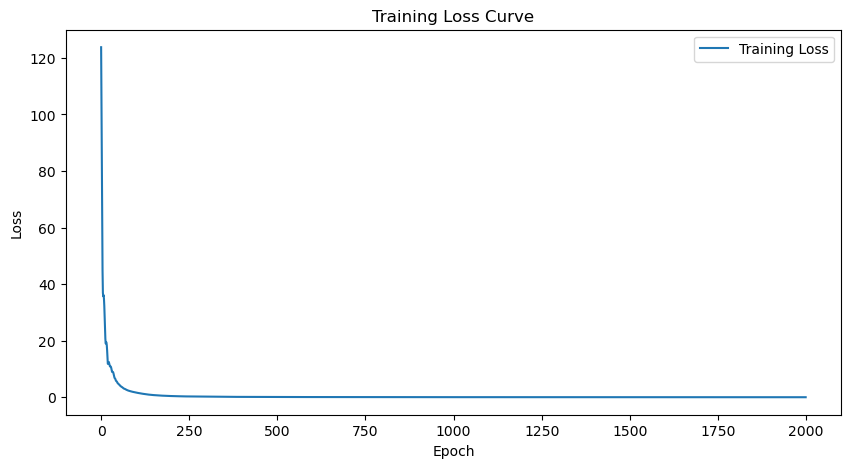

Final Model Accuracy: 60.41%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token_TSNE2_TSNE2.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



/tmp/ipykernel_2346938/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
